![logo](../../picture/license_header_logo.png)

> **Copyright (c) 2020-2021 CertifAI Sdn. Bhd.**<br>
<br>
This program is part of OSRFramework. You can redistribute it and/or modify
<br>it under the terms of the GNU Affero General Public License as published by
<br>the Free Software Foundation, either version 3 of the License, or
<br>(at your option) any later version.
<br>
<br>This program is distributed in the hope that it will be useful,
<br>but WITHOUT ANY WARRANTY; without even the implied warranty of
<br>MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
<br>GNU Affero General Public License for more details.
<br>
<br>You should have received a copy of the GNU Affero General Public License
<br>along with this program.  If not, see <http://www.gnu.org/licenses/>.
<br>

Authored by: [Annabelle Ng](mailto:annabelle.ng@skymind.my)

## Table of Content


##### Build an Image Classification Model
* [Download Data](#download)
* [Data Preprocessing and Augmentation ](#data-aug)
* [Dataset and Dataloader](#dataset-dataloader)
* [Model](#model)
* [Training With Early Stopping](#training)
* [Inference](#inference)

* [Appendix](#Appendix)

### Build an Image Classification Model <a id="exercise"></a>

We’ll be building a simple fruit classifier using CNN model here. There are only 3 classes of images in our example here which are **apple, grapes and lemon**. There are 100 images for each category in the train set and 30 images for each category in the validation and test set respectively.

We will train a simple two-layers **CNN model** uisng `PyTorch` library and save it to deploy later. Read more about `PyTorch` [here](https://github.com/pytorch/pytorch).

Let's get started.

In [1]:
import os
import numpy as np
from pathlib import Path
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import wget
import zipfile
%matplotlib inline
%load_ext tensorboard

##### Download Data <a id="download"></a>

Let's load the data. Run the two code blocks below.

In [2]:
def download(source, target, filename):
    if not os.path.exists(target):
        os.mkdir(target)
    targt_file = str(Path(target).joinpath(filename))
    if os.path.exists(targt_file):
        print('data already exists, skipping download')
        return

    print("Downloading from {} to {}".format(source, target))
    wget.download(source, targt_file)
    print("\nDone!")

    print('Unzipping {}'.format(targt_file))
    zipr = zipfile.ZipFile(targt_file)
    zipr.extractall(target)
    zipr.close()

    print('Done!')

In [3]:
source = 'https://s3.eu-central-1.wasabisys.com/certifai/deployment-training-labs/fruits_image_classification-20210604T123547Z-001.zip'
target = '../../resources/data/'
filename = 'fruits_image_classification.zip'
download(source, target, filename)

data already exists, skipping download


Now, let's check our data.

In [4]:
# The data is located in the resources/data folder
datadir = '../../resources/data/fruits_image_classification'
traindir = datadir + '/train/'
validdir = datadir + '/validation/'
testdir = datadir + '/test/'
dirtytestdir = datadir + '/dirty_test/'

In [5]:
# Check our images number in the train, val and test folders (Optional)
# Iterate through each category
categories = []
train_size, val_size, test_size, dirtytest_size = 0, 0, 0, 0

for category in os.listdir(traindir):
    categories.append(category)

    # Number of images added up
    train_imgs = os.listdir(Path(traindir)/f'{category}')
    valid_imgs = os.listdir(Path(validdir)/f'{category}')
    test_imgs = os.listdir(Path(testdir)/f'{category}')
    dirtytest_imgs = os.listdir(Path(dirtytestdir)/f'{category}')
    train_size += len(train_imgs)
    val_size += len(valid_imgs)
    test_size += len(test_imgs)
    dirtytest_size += len(dirtytest_imgs)

print(f'Train set: {train_size}, Validation set: {val_size}, Test set:{test_size}, Dirty test set:{dirtytest_size}', end='\n\n')
print(categories)
print(f'\nNumber of categories: {len(categories)}')

Train set: 300, Validation set: 90, Test set:90, Dirty test set:90

['apple', 'grapes', 'lemon']

Number of categories: 3


##### Data Preprocessing and Augmentation <a id=data-aug></a>

Image preprocessing are the steps taken to format images before they are used by model training and inference. This includes, but is not limited to, resizing, orienting, and color corrections.  

Image augmentation are manipulations applied to images to create different versions of similar content in order to expose the model to a wider array of training examples. 

We'll apply data augmentation to our train set for our model to generalise better.

In [6]:
# We will need our input in tensors form, must `transforms.ToTensor(),`

image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        # You can set 'Resize' and 'Crop' to higher resolution for better result
        transforms.Resize(180),

        # Data augmented here
        # Use (224, 224) if you want to train on Imagenet pre-trained model
        transforms.RandomCrop(150),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),

        transforms.ToTensor(),
    ]),

    # Validation and Inference do not use augmentation
    'valid':
    transforms.Compose([
        # You can set to higher resolution for better result
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
    ]),
}

##### Dataset and Dataloader <a id=dataset-dataloader></a>

`Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the `Dataset` to enable easy access to the samples during model training with the batch size we set.

Next, we are going to put our data into `Dataset` and `Dataloader`.

By using `datasets.ImageFolder` to make a Dataset, `PyTorch` will automatically associate images with the correct labels provided our directory is arranged as the architecture shown below:

 /datadir \
&emsp;    /train \
&emsp;&emsp;            /class_1 \
&emsp;&emsp;            /class_2 \
&emsp;&emsp;            . \
&emsp;&emsp;            . \
&emsp;    /valid \
&emsp;&emsp;            /class_1 \
&emsp;&emsp;            /class_2 \
&emsp;&emsp;             . \
&emsp;&emsp;             . 

In [7]:
torch.manual_seed(123)

# Datasets from folders
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'valid':
    datasets.ImageFolder(root=validdir, transform=image_transforms['valid']),
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=10, shuffle=True),
    'valid': DataLoader(data['valid'], batch_size=10, shuffle=True)
}

In [8]:
# To check the iterative behavior of the DataLoader (optional)
# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([10, 3, 150, 150]), torch.Size([10]))

Labels: 
tensor([2, 1, 0, 1, 1, 0, 0, 0, 2, 1])
lemon, grapes, apple, grapes, grapes, apple, apple, apple, lemon, grapes, 

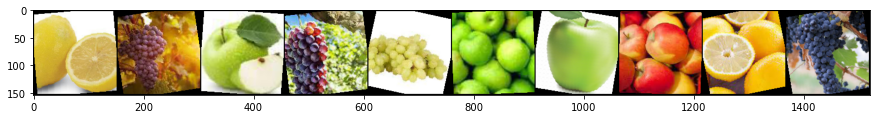

In [9]:
# Visualization of images in dataloader (optional)
# nrow = Number of images displayed in each row of the grid.
# Clip image pixel value to 0-1
grid = torchvision.utils.make_grid(np.clip(features[0:10], 0, 1), nrow=10)

plt.figure(figsize=(15, 15))
# Transpose to show in rows / horizontally
plt.imshow(np.transpose(grid, (1, 2, 0)))

print("Labels: ")
print(labels[0:10])
for i in labels[0:10]:
    print(categories[i] + ", ", end="")

##### Model <a id=model></a>

There are two approaches of modeling using `PyTorch` library:
- Subclassing `nn.Module`
- Calling the `nn.Sequential()`

We will show you how to build a CNN model by subclassing `nn.Module`. You can also do subclassing `nn.Module` with `PyTorch` functional API.

Also, check out the documentation of [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) if you are new to CNN.

In [10]:
num_input = 3  # channels
num_output = 3

In [11]:
# Build CNN model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=num_input, out_channels=6, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        # Note that the input of this layers is depending on your input image sizes
        self.fc1 = nn.Linear(in_features=34*34*16, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_output)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu1(self.conv1(x)))
        x = self.pool(self.relu2(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

##### Training <a id=training></a>

We'll start our training soon! We have built a train function which includes the training steps needed. 

Below is an explanation of our train function:

1. Compute forward propagation with `model(images)` on train set.
2. Compute loss by calling `criterion(y_pred, labels)`
3. In each iteration/ for each batch, start with `optimizer.zero_grad()` to clear previously computed gradients
4. Compute backward propagation with `loss.backward()`
5. Update parameters with calling `optimizer.step()`
6. Increment our `running_loss` with the loss of our current iteration/batch
7. Compute the loss in the current epoch by dividing the accumulated loss and the amount of data samples
8. Write the result to `tensorboard` and save the best model 
9. Go to another phase, zero the variables and start validation using validation set 
10. Do the same thing on validation set except setting the model to inference mode and bypassing the backpropogation and updating parameters 
11. Stop the training if early stopping criteria is met, if not, go to next epoch and start over

In [12]:
def train(model, loader, optimizer, criterion, saving_path, n_epochs_stop, epochs):
    epochs_no_improve = 0
    min_val_loss = np.Inf
    early_stop = False

    for i in range(1, epochs + 1):

        for phase in ['train', 'valid']:
            running_loss = 0.0
            running_size = 0.0
            epoch_loss = 0.0
            correct = 0

            if phase == 'train':
                model.train()
            else:
                # To set dropout and batch normalization layers to evaluation mode before running inference
                model.eval()

            for images, labels in loader[phase]:

                with torch.set_grad_enabled(phase == 'train'):
                    # Predict and compute loss
                    y_pred = model(images)
                    loss = criterion(y_pred, labels)

                    # Backpropogate and update parameters
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # Note: the last batch size will be the remainder of data size divided by batch size
                # Thus, we multiply one batch loss with the number of items in batch and divide it by total size later
                # The final running size is equal to the data size
                running_loss += loss.item()*y_pred.size(0)
                running_size += y_pred.size(0)

                # The predictions is the index of the maximum values in the output of model
                predictions = torch.max(y_pred, 1)[1]
                correct += (predictions == labels).sum().item()

            epoch_loss = running_loss / running_size
            epoch_accuracy = correct / running_size
            writer.add_scalars('Loss', {phase: epoch_loss}, i)
            writer.add_scalars('Accuracy', {phase: epoch_accuracy}, i)

            # Print score at every epoch
            if (i % 1 == 0 or i == 1):
                if phase == 'train':
                    print(f'Epoch {i}:')
                print(f'  {phase.upper()} Loss: {epoch_loss}')
                print(f'  {phase.upper()} Accuracy: {epoch_accuracy}')

            # For visualization (Optional)
            loss_score[phase].append(epoch_loss)

            # Early stopping
            if phase == 'valid':
                if epoch_loss < min_val_loss:
                    # Save the model before the epochs start to not improving
                    torch.save(model.state_dict(), saving_path)
                    print(f"Model saved at Epoch {i} \n")
                    epochs_no_improve = 0
                    min_val_loss = epoch_loss

                else:
                    epochs_no_improve += 1
                    print('\tepochs_no_improve:',
                          epochs_no_improve, ' at Epoch', i)

            if epochs_no_improve == n_epochs_stop:
                print('\nEarly stopping!')
                early_stop = True
                break

        # To exit loop
        if early_stop:
            print("Stopped")
            break

    writer.close()

Here, we'll instantiate our model and setup the optimizer and loss function for training. The training will be stopped if result on validation set is not improving for `n_epochs_stop` (5 epochs) or else the training will continue until the max epochs, 50.

In [13]:
# Define model, dataloaders, optimizer, criterion
model = Net()
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.01, momentum=1e-4, nesterov=True)
criterion = nn.CrossEntropyLoss()

# Setup writer for tensorboard and also a saving_path to save model (Optional)
writer = SummaryWriter('logs/fruits_classifier')
if not os.path.exists('../../resources/model'):
    os.mkdir('../../resources/model')
saving_path = '../../resources/model/fruit_classifier_state_dict.pt'

n_epochs_stop = 5
epochs = 50
loss_score = {'train': [], 'valid': []}

We have everything prepared, start the training now!

In [14]:
train(model, dataloaders, optimizer, criterion,
      saving_path, n_epochs_stop, epochs)

Epoch 1:
  TRAIN Loss: 1.098261042435964
  TRAIN Accuracy: 0.3333333333333333
  VALID Loss: 1.095142576429579
  VALID Accuracy: 0.3333333333333333
Model saved at Epoch 1 

Epoch 2:
  TRAIN Loss: 1.0942630290985107
  TRAIN Accuracy: 0.3333333333333333
  VALID Loss: 1.0910248359044392
  VALID Accuracy: 0.3333333333333333
Model saved at Epoch 2 

Epoch 3:
  TRAIN Loss: 1.088458518187205
  TRAIN Accuracy: 0.36
  VALID Loss: 1.0846034950680203
  VALID Accuracy: 0.3333333333333333
Model saved at Epoch 3 

Epoch 4:
  TRAIN Loss: 1.0790639321009319
  TRAIN Accuracy: 0.3933333333333333
  VALID Loss: 1.0714702208836873
  VALID Accuracy: 0.5
Model saved at Epoch 4 

Epoch 5:
  TRAIN Loss: 1.0625656803448995
  TRAIN Accuracy: 0.49
  VALID Loss: 1.0458353294266596
  VALID Accuracy: 0.36666666666666664
Model saved at Epoch 5 

Epoch 6:
  TRAIN Loss: 1.019965801636378
  TRAIN Accuracy: 0.4533333333333333
  VALID Loss: 0.9887867636150784
  VALID Accuracy: 0.5777777777777777
Model saved at Epoch 6 

Ep

Visualise the loss score.

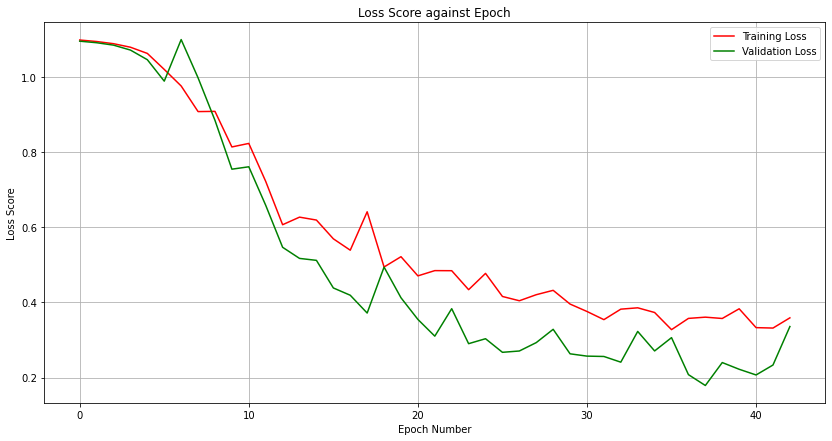

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
ax.set_title("Loss Score against Epoch")
ax.grid(b=True)
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Loss Score")
ax.plot(loss_score['train'], color='red', label='Training Loss')
ax.plot(loss_score['valid'], color='green', label='Validation Loss')
ax.legend()
plt.show()

Visualise the score using tensorboard.

In [16]:
%tensorboard --logdir logs/fruits_classifier --port 6060

##### Inference <a id=inference></a>

We know our model does well on training and even validation data, but the ultimate test is how it performs on a hold-out testing set it has not seen before. Let's do some inferencing. 

Load the best model that we have saved. 

In [17]:
# Load model (optional)
# To load a saved state dict, we need to instantiate the model first
best_model = Net()

# Notice that the load_state_dict() function takes a dictionary object, NOT a path to a saved object.
# This means that you must deserialize the saved state_dict before you pass it to the load_state_dict() function.
best_model.load_state_dict(torch.load(
    '../../resources/model/fruit_classifier_state_dict.pt'))
best_model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (fc1): Linear(in_features=18496, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
  (relu): ReLU()
)

Inference on test set.

In [18]:
%%time

test_data = datasets.ImageFolder(
    root=testdir, transform=image_transforms['valid'])
testloader = DataLoader(test_data, len(test_data), shuffle=False)

with torch.no_grad():
    for images, labels in testloader:
        correct = 0
        y_pred = best_model(images)
        predictions = torch.max(y_pred, 1)[1]
        print(predictions)
        print(labels)
        correct += (predictions == labels).sum().item()
        accuracy = correct / len(test_data)
        print(f"Test Accuracy: {accuracy}")

tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
Test Accuracy: 0.9111111111111111
Wall time: 708 ms


Note that we have prepared an extra test set which is named as `dirty_test/` folder which contains images that are harder to classify compared to the test set.

In [19]:
%%time

# Inference on dirty test set
dirtytest_data = datasets.ImageFolder(
    root=dirtytestdir, transform=image_transforms['valid'])
dirtytestloader = DataLoader(
    dirtytest_data, len(dirtytest_data), shuffle=False)

with torch.no_grad():
    for images, labels in dirtytestloader:
        correct = 0
        y_pred = best_model(images)
        predictions = torch.max(y_pred, 1)[1]
        print(predictions)
        print(labels)
        correct += (predictions == labels).sum().item()
        accuracy = correct / len(test_data)
        print(f"Test Accuracy: {accuracy}")

tensor([0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 2, 0, 2, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 1, 1, 2])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
Test Accuracy: 0.7333333333333333
Wall time: 241 ms


### Appendix

##### Pre-trained Model <a id=pre-trained-model></a>

`PyTorch` has a models subpackage that contains model architectures and pretrained models that have been trained on 1000 classes of images (millions of images) in Imagenet. See the list of models available in `torchvision.models` [here](https://pytorch.org/vision/stable/models.html).

For this example, we’ll be using the VGG-16. Assuming the given number of training samples (images) are not sufficient enough for building a classifier, in this case, VGG can be easily leveraged for feature extraction as it is trained on millions of images. Though it didn’t record the lowest error and has a higher inference time due to large number of parameters, it is quicker to train than other models.

Here are the general steps to use a pre-trained model:
- Load in pre-trained weights / model trained on a large dataset.
- Freeze all the weights in the front (convolutional) layers (adjusting layers to freeze based on the similarity of new task to the trained large dataset).
- Replace the end of the network with a custom classifier (set the number of outputs to be the number of classes).
- Train only on the unfreezed layers for the task.

In [20]:
# Load vgg pre-trained model or others you prefer
import torchvision.models as models
model = models.vgg16(pretrained=True)

In [21]:
# Freeze pre-trained model weights
for param in model.parameters():
    param.requires_grad = False

In [22]:
import torch.nn as nn
torch.manual_seed(0)

# Add custom classifier / output layer
model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 256),  # model.classifier[6].in_features = 4096
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 3),
    nn.LogSoftmax(dim=1))

print(f'Fully connected layers in the pre-trained model:\n {model.classifier}')

Fully connected layers in the pre-trained model:
 Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=3, bias=True)
    (4): LogSoftmax(dim=1)
  )
)


In [23]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,310,147 total parameters.
1,049,603 training parameters.


##### Train with GPU (Optional)

One of the benefits of using PyTorch is we can easily move different elements of the model or data to CPU/GPU or to multiple GPUs. Using GPU will make the neural network training much more faster.

Setup Steps:

- Install cuDNN 7.6.5 in your machine. Download it at this [site](https://developer.nvidia.com/rdp/cudnn-archive). For more, you can refer to [cuDNN installation guide](https://docs.nvidia.com/deeplearning/cudnn/install-guide/index.html).

- Then, run the following in your terminal to install cuda in your conda environment if `cudatoolkit` is not installed in your environment. 

```sh
conda install cudatoolkit=10.2 -c pytorch
```

- Make sure your driver is updated. If you have problem using CUDA with your driver, check your driver version using `nvidia-smi` in your terminal, you will be able to run CUDA 10.2 if your driver-version is above 440.33 in Linux or above 441.22 in Windows. Run GPU using earlier version of CUDA if you can't use the CUDA 10.2. [source](https://docs.nvidia.com/cuda/cuda-toolkit-release-notes/index.html)

- Check if your cuda is available in your terminal: 
```sh
python
>>> import torch
>>> torch.cuda.is_available()
```
    You should receive 'True'.

- If you cuda is not detected in jupyter notebook, try running the following in your command prompt / terminal:
```sh
conda install -n <YOUR_ENV_NAME> nb_conda_kernels
python -m ipykernel install --user --name <YOUR_ENV_NAME> --display-name "Python (<YOUR_ENV_NAME>)"
```
and restart the jupyter notebook.

If your GPU is ready, you can add this few lines code in the code above to move the model and tensors to GPU. 

In [24]:
# Move model and variables to gpu torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

# Also move input and labels to GPU
# which is after the 'for images, labels in dataloaders['train']:'
# exmmple
for images, labels in dataloaders['train']:
    # Move tensors to compute using gpu
    if torch.cuda.is_available():
        images, labels = images.to(device), labels.to(device)